# Fantasy Draft Recommender System

This notebook will help you win your fantasy draft -- or make you lose miserably. TBD

This notebook utilizes reinforcment learning on previous NFL drafts to help determine the optimal draft day strategy.

Pulls data from here: https://github.com/nflverse/nfl_data_py

In [124]:
import torch
import torch.nn as nn
import torch.optim as optim

print(torch.cuda.is_available())
print(torch.version.cuda)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

True
12.1


In [125]:
import math
import random
import numpy as np
import pandas as pd
import nfl_data_py as nfl
import pandas as pd

# Pull weekly data for the last few seasons
years = [2018, 2019, 2020, 2021, 2022, 2023, 2024]

# Pull the core dataframes
weekly_df = nfl.import_weekly_data(years)
seasonal_df = nfl.import_seasonal_data(years)
rosters_df = nfl.import_weekly_rosters(years)
draft_df = nfl.import_draft_picks(years)
combine_df = nfl.import_combine_data(years)
id_map = nfl.import_ids()
pbp = nfl.import_pbp_data(years)

Downcasting floats.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2023 done.
2024 done.
Downcasting floats.


In [126]:
def show_info(df, name):
    print(f"--- {name} ---")
    print("columns:", list(df.columns))
    print("dtypes:\n", df.dtypes)
    print("head:\n", df.head(2))
    print()

show_info(weekly_df, "weekly_df")
show_info(rosters_df, "rosters_df")

keys = ['player_id', 'season', 'week']
print("keys present in weekly_df:", [k for k in keys if k in weekly_df.columns])
print("keys present in rosters_df:", [k for k in keys if k in rosters_df.columns])


--- weekly_df ---
columns: ['player_id', 'player_name', 'player_display_name', 'position', 'position_group', 'headshot_url', 'recent_team', 'season', 'week', 'season_type', 'opponent_team', 'completions', 'attempts', 'passing_yards', 'passing_tds', 'interceptions', 'sacks', 'sack_yards', 'sack_fumbles', 'sack_fumbles_lost', 'passing_air_yards', 'passing_yards_after_catch', 'passing_first_downs', 'passing_epa', 'passing_2pt_conversions', 'pacr', 'dakota', 'carries', 'rushing_yards', 'rushing_tds', 'rushing_fumbles', 'rushing_fumbles_lost', 'rushing_first_downs', 'rushing_epa', 'rushing_2pt_conversions', 'receptions', 'targets', 'receiving_yards', 'receiving_tds', 'receiving_fumbles', 'receiving_fumbles_lost', 'receiving_air_yards', 'receiving_yards_after_catch', 'receiving_first_downs', 'receiving_epa', 'receiving_2pt_conversions', 'racr', 'target_share', 'air_yards_share', 'wopr', 'special_teams_tds', 'fantasy_points', 'fantasy_points_ppr']
dtypes:
 player_id                       obje

Renamed columns: {'gsis_id': 'player_id'}
Renamed columns: {'pfr_id': 'player_id'}
Number of players on active rosters: 0
weekly x rosters join: {'left_only': 38568, 'right_only': 0, 'both': 0}
season merge counts: {'both': 38545, 'left_only': 23, 'right_only': 0}
draft merge counts: {'left_only': 34046, 'both': 4522, 'right_only': 0}
combine merge counts: {'left_only': 38568, 'right_only': 0, 'both': 0}
Final merged shape: (38568, 162)


/tmp/ipykernel_26241/363664068.py:123: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pbp_df['long_pass_completion_40'] = (
/tmp/ipykernel_26241/363664068.py:128: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pbp_df['long_pass_td_40'] = (
/tmp/ipykernel_26241/363664068.py:134: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newfr

weekly_df columns:
Index(['player_id', 'player_name', 'player_display_name', 'position',
       'position_group', 'headshot_url', 'recent_team', 'season', 'week',
       'season_type', 'opponent_team', 'completions', 'attempts',
       'passing_yards', 'passing_tds', 'interceptions', 'sacks', 'sack_yards',
       'sack_fumbles', 'sack_fumbles_lost', 'passing_air_yards',
       'passing_yards_after_catch', 'passing_first_downs', 'passing_epa',
       'passing_2pt_conversions', 'pacr', 'dakota', 'carries', 'rushing_yards',
       'rushing_tds', 'rushing_fumbles', 'rushing_fumbles_lost',
       'rushing_first_downs', 'rushing_epa', 'rushing_2pt_conversions',
       'receptions', 'targets', 'receiving_yards', 'receiving_tds',
       'receiving_fumbles', 'receiving_fumbles_lost', 'receiving_air_yards',
       'receiving_yards_after_catch', 'receiving_first_downs', 'receiving_epa',
       'receiving_2pt_conversions', 'racr', 'target_share', 'air_yards_share',
       'wopr', 'special_teams_td

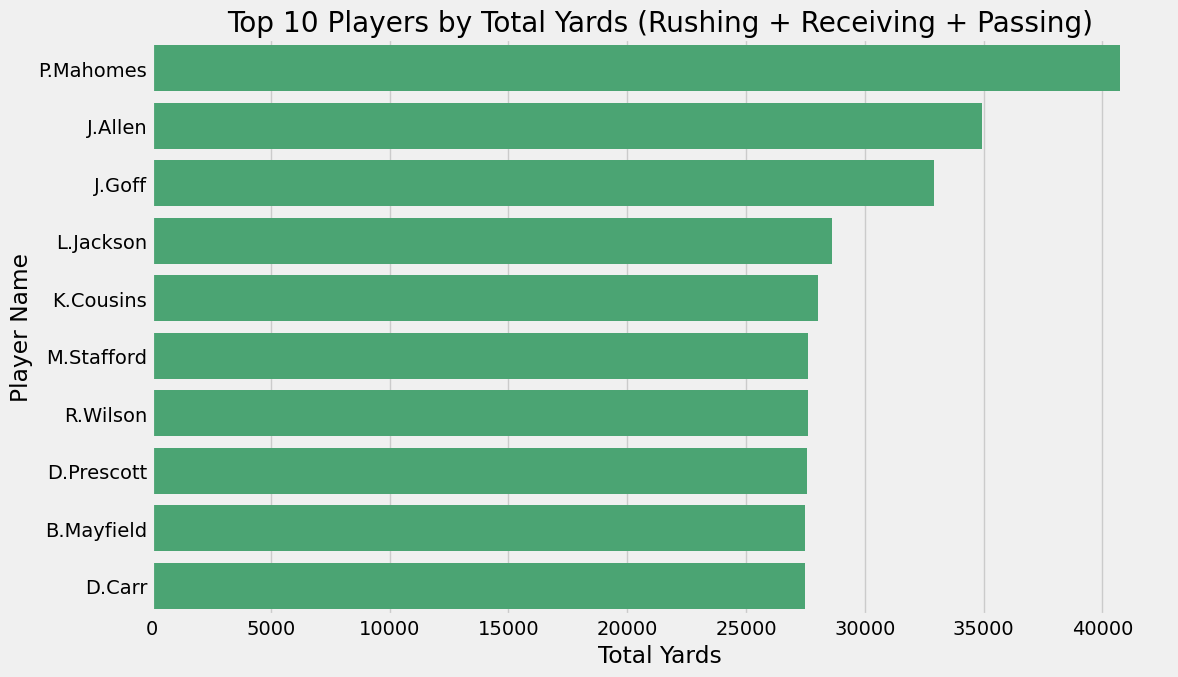

In [127]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# --- Your original code for cleaning and merging ---

def ensure_cols(df):
    rename_map = {}
    alt_names = {
        'player_id': ['nflverse_player_id', 'nfl_id', 'gsis_id', 'pfr_id', 'player'],
        'week': ['week_id', 'game_week'],
        'season': ['season_year']
    }
    for canonical, alts in alt_names.items():
        if canonical not in df.columns:
            for alt in alts:
                if alt in df.columns:
                    rename_map[alt] = canonical
    if rename_map:
        df = df.rename(columns=rename_map)
        print("Renamed columns:", rename_map)

    for k in ['season', 'week']:
        if k in df.columns:
            try:
                df[k] = df[k].astype('Int64')
            except Exception:
                pass

    df = df.loc[:, ~df.columns.duplicated()]
    return df

weekly_df = ensure_cols(weekly_df)
rosters_df = ensure_cols(rosters_df)
seasonal_df = ensure_cols(seasonal_df)
draft_df = ensure_cols(draft_df)
combine_df = ensure_cols(combine_df)

def add_player_id(df, id_map):
    if 'player_id' not in df.columns:
        for key in ['pfr_id', 'gsis_id', 'nfl_id', 'combine_id']:
            if key in df.columns and key in id_map.columns:
                df = df.merge(
                    id_map[[key, 'nflverse_player_id']],
                    on=key,
                    how='left'
                )
                df = df.rename(columns={'nflverse_player_id': 'player_id'})
                break
    df = df.loc[:, ~df.columns.duplicated()]
    return df

weekly_df = add_player_id(weekly_df, id_map)
rosters_df = add_player_id(rosters_df, id_map)
seasonal_df = add_player_id(seasonal_df, id_map)
draft_df = add_player_id(draft_df, id_map)
combine_df = add_player_id(combine_df, id_map)

def safe_merge(left, right, **kwargs):
    left = left.loc[:, ~left.columns.duplicated()]
    right = right.loc[:, ~right.columns.duplicated()]
    merged = pd.merge(left, right, **kwargs)
    merged = merged.loc[:, ~merged.columns.duplicated()]
    return merged

# Filter rosters_df to include only players with an 'Active' status
# Added .copy() to avoid a SettingWithCopyWarning in some pandas versions.
rosters_df = rosters_df[rosters_df['status'] == 'Active'].copy()
print(f"Number of players on active rosters: {len(rosters_df)}")

merged_df = safe_merge(
    weekly_df,
    rosters_df,
    on=['player_id', 'season', 'week'],
    how='left',
    suffixes=('_weekly', '_roster'),
    indicator='roster_merge'
)
print("weekly x rosters join:", merged_df['roster_merge'].value_counts().to_dict())

seasonal_df = seasonal_df.drop(columns=['player_name', 'position', 'team_abbr'], errors='ignore')
merged_df = safe_merge(
    merged_df,
    seasonal_df,
    on=['player_id', 'season'],
    how='left',
    suffixes=('', '_season'),
    indicator='seasonal_merge'
)
print("season merge counts:", merged_df['seasonal_merge'].value_counts().to_dict())

draft_df = draft_df.rename(columns={'round': 'draft_round', 'pick': 'draft_pick'})
merged_df = safe_merge(
    merged_df,
    draft_df[['player_id', 'season', 'draft_round', 'draft_pick']],
    on=['player_id', 'season'],
    how='left',
    indicator='draft_merge'
)
print("draft merge counts:", merged_df['draft_merge'].value_counts().to_dict())

merged_df = safe_merge(
    merged_df,
    combine_df,
    on='player_id',
    how='left',
    indicator='combine_merge'
)
print("combine merge counts:", merged_df['combine_merge'].value_counts().to_dict())

# Drop all indicator columns at the end
merged_df.drop(columns=['roster_merge', 'seasonal_merge', 'draft_merge', 'combine_merge'], inplace=True)

print("Final merged shape:", merged_df.shape)

# --- 6. Aggregate 40+ yard plays from pbp ---

def aggregate_long_plays(pbp_df):
    pbp_df['yards_gained'] = pd.to_numeric(pbp_df.get('yards_gained', 0), errors='coerce').fillna(0)
    pbp_df['pass_length'] = pd.to_numeric(pbp_df.get('pass_length', 0), errors='coerce').fillna(0)

    pbp_df['long_pass_completion_40'] = (
        (pbp_df['passer_player_id'].notna()) &
        (pbp_df['yards_gained'] >= 40)
    ).astype(int)

    pbp_df['long_pass_td_40'] = (
        (pbp_df['passer_player_id'].notna()) &
        (pbp_df['touchdown'] == 1) &
        (pbp_df['yards_gained'] >= 40)
    ).astype(int)

    pbp_df['long_rush_40'] = (
        (pbp_df['rusher_player_id'].notna()) &
        (pbp_df['yards_gained'] >= 40)
    ).astype(int)

    pbp_df['long_rush_td_40'] = (
        (pbp_df['rusher_player_id'].notna()) &
        (pbp_df['touchdown'] == 1) &
        (pbp_df['yards_gained'] >= 40)
    ).astype(int)

    pbp_df['long_receive_40'] = (
        (pbp_df['receiver_player_id'].notna()) &
        (pbp_df['yards_gained'] >= 40)
    ).astype(int)

    pbp_df['long_receive_td_40'] = (
        (pbp_df['receiver_player_id'].notna()) &
        (pbp_df['touchdown'] == 1) &
        (pbp_df['yards_gained'] >= 40)
    ).astype(int)

    pass_agg = pbp_df.groupby(['season', 'week', 'passer_player_id']).agg({
        'long_pass_completion_40': 'sum',
        'long_pass_td_40': 'sum'
    }).reset_index().rename(columns={'passer_player_id':'player_id'})

    rush_agg = pbp_df.groupby(['season', 'week', 'rusher_player_id']).agg({
        'long_rush_40': 'sum',
        'long_rush_td_40': 'sum'
    }).reset_index().rename(columns={'rusher_player_id':'player_id'})

    rec_agg = pbp_df.groupby(['season', 'week', 'receiver_player_id']).agg({
        'long_receive_40': 'sum',
        'long_receive_td_40': 'sum'
    }).reset_index().rename(columns={'receiver_player_id':'player_id'})

    combined = pd.merge(pass_agg, rush_agg, on=['season','week','player_id'], how='outer')
    combined = pd.merge(combined, rec_agg, on=['season','week','player_id'], how='outer')

    combined[['long_pass_completion_40', 'long_pass_td_40',
              'long_rush_40', 'long_rush_td_40',
              'long_receive_40', 'long_receive_td_40']] = combined[[
                  'long_pass_completion_40', 'long_pass_td_40',
                  'long_rush_40', 'long_rush_td_40',
                  'long_receive_40', 'long_receive_td_40']].fillna(0)

    return combined

agg_long_plays = aggregate_long_plays(pbp)

# --- 7. Merge into merged_df ---

merged_df = merged_df.rename(columns={'season_x':'season'}) if 'season_x' in merged_df.columns else merged_df

merged_df = pd.merge(
    merged_df,
    agg_long_plays,
    on=['season', 'week', 'player_id'],
    how='left'
)

long_cols = [
    'long_pass_completion_40', 'long_pass_td_40',
    'long_rush_40', 'long_rush_td_40',
    'long_receive_40', 'long_receive_td_40'
]

merged_df[long_cols] = merged_df[long_cols].fillna(0)

for df_name, df in [('weekly_df', weekly_df), ('pbp', pbp), ('seasonal_df', seasonal_df)]:
    print(f"{df_name} columns:")
    print(df.columns)
    print('-' * 40)

# Add total_fumbles_lost column to weekly_df first
weekly_df['total_fumbles_lost'] = (
    weekly_df['sack_fumbles_lost'].fillna(0) +
    weekly_df['rushing_fumbles_lost'].fillna(0) +
    weekly_df['receiving_fumbles_lost'].fillna(0)
)

weekly_df['total_two_point_conversions'] = (
    weekly_df['passing_2pt_conversions'].fillna(0) +
    weekly_df['rushing_2pt_conversions'].fillna(0) +
    weekly_df['receiving_2pt_conversions'].fillna(0)
)

merged_df = merged_df.merge(
    weekly_df[['player_id', 'season', 'week', 'total_two_point_conversions']],
    on=['player_id', 'season', 'week'],
    how='left'
)

merged_df['total_two_point_conversions'] = merged_df['total_two_point_conversions'].fillna(0)

merged_df = merged_df.merge(
    weekly_df[['player_id', 'season', 'week', 'total_fumbles_lost']],
    on=['player_id', 'season', 'week'],
    how='left'
)

# --- 8. Update fantasy points calculation ---

def compute_fantasy_points(df):
    def get_col_or_zero(df, col):
        if col in df.columns:
            return df[col].fillna(0)
        else:
            return pd.Series(0, index=df.index)

    passing_yards = get_col_or_zero(df, 'passing_yards')
    passing_tds = get_col_or_zero(df, 'passing_tds')
    interceptions = get_col_or_zero(df, 'interceptions')
    rushing_yards = get_col_or_zero(df, 'rushing_yards')
    rushing_tds = get_col_or_zero(df, 'rushing_tds')
    receptions = get_col_or_zero(df, 'receptions')
    receiving_yards = get_col_or_zero(df, 'receiving_yards')
    receiving_tds = get_col_or_zero(df, 'receiving_tds')
    fumbles_lost = get_col_or_zero(df, 'total_fumbles_lost')
    sacks = get_col_or_zero(df, 'sacks')
    two_pt_conversions = get_col_or_zero(df, 'total_two_point_conversions')
    pick_six = get_col_or_zero(df, 'pick_six')
    long_pass_cmp_40 = get_col_or_zero(df, 'long_pass_completion_40')
    long_pass_td_40 = get_col_or_zero(df, 'long_pass_td_40')
    long_rush_40 = get_col_or_zero(df, 'long_rush_40')
    long_rush_td_40 = get_col_or_zero(df, 'long_rush_td_40')
    long_rec_40 = get_col_or_zero(df, 'long_receive_40')
    long_rec_td_40 = get_col_or_zero(df, 'long_receive_td_40')
    sack_yards = get_col_or_zero(df, 'sack_yards')

    df['fantasy_points_custom'] = (
        (passing_yards / 25) +
        (passing_tds * 6) +
        (interceptions * -2) +
        (rushing_yards / 10) +
        (rushing_tds * 6) +
        (receptions * 0.5) +
        (receiving_yards / 10) +
        (receiving_tds * 6) +
        (fumbles_lost * -2) +
        (sacks * -1) +
        (two_pt_conversions * 2) +
        (pick_six * -6) +
        (long_pass_cmp_40 * 1) +
        (long_pass_td_40 * 4) +
        (long_rush_40 * 2) +
        (long_rush_td_40 * 4) +
        (long_rec_40 * 2) +
        (long_rec_td_40 * 4)
    )
    return df

merged_df = compute_fantasy_points(merged_df)

# --- 9. Visualization example: Top 10 Players by Total Yards ---

merged_df['total_yards'] = (
    merged_df['rushing_yards'].fillna(0) +
    merged_df['receiving_yards'].fillna(0) +
    merged_df['passing_yards'].fillna(0)
)

if 'player_name_weekly' in merged_df.columns:
    merged_df['player_name'] = merged_df['player_name_weekly']
elif 'player_name_roster' in merged_df.columns:
    merged_df['player_name'] = merged_df['player_name_roster']
else:
    merged_df['player_name'] = "Unknown"
        
top_players = (
    merged_df.groupby('player_name', as_index=False)['total_yards']
    .sum()
    .sort_values(by='total_yards', ascending=False)
    .head(10)
)

plt.figure(figsize=(12, 7))
sns.barplot(data=top_players, y='player_name', x='total_yards', color='mediumseagreen')
plt.title("Top 10 Players by Total Yards (Rushing + Receiving + Passing)")
plt.xlabel("Total Yards")
plt.ylabel("Player Name")
plt.tight_layout()
plt.show()

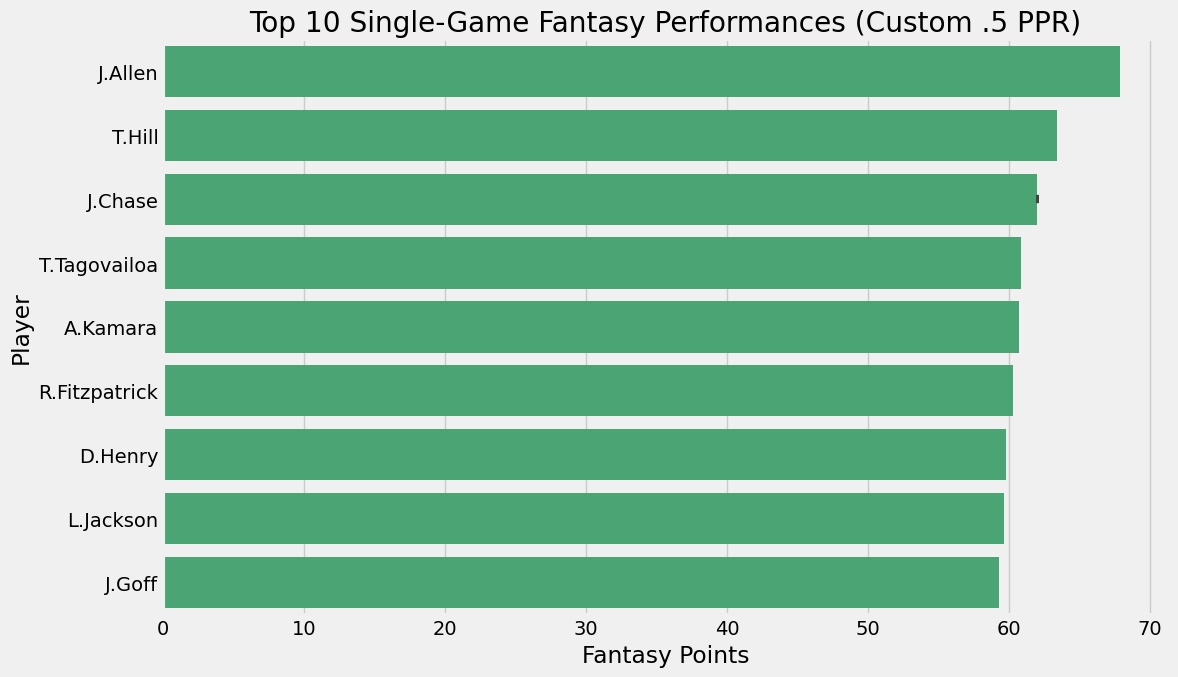

In [128]:
top_custom_fantasy = merged_df.sort_values(by='fantasy_points_custom', ascending=False).head(10)

plt.figure(figsize=(12, 7))
sns.barplot(data=top_custom_fantasy, y='player_name', x='fantasy_points_custom', color='mediumseagreen')
plt.title('Top 10 Single-Game Fantasy Performances (Custom .5 PPR)')
plt.xlabel('Fantasy Points')
plt.ylabel('Player')
plt.tight_layout()
plt.show()


Using latest season: 2024
Columns in merged_df: player_id
Columns in merged_df: player_name_weekly
Columns in merged_df: player_display_name
Columns in merged_df: position_weekly
Columns in merged_df: position_group
Columns in merged_df: headshot_url_weekly
Columns in merged_df: recent_team
Columns in merged_df: season
Columns in merged_df: week
Columns in merged_df: season_type
Columns in merged_df: opponent_team
Columns in merged_df: completions
Columns in merged_df: attempts
Columns in merged_df: passing_yards
Columns in merged_df: passing_tds
Columns in merged_df: interceptions
Columns in merged_df: sacks
Columns in merged_df: sack_yards
Columns in merged_df: sack_fumbles
Columns in merged_df: sack_fumbles_lost
Columns in merged_df: passing_air_yards
Columns in merged_df: passing_yards_after_catch
Columns in merged_df: passing_first_downs
Columns in merged_df: passing_epa
Columns in merged_df: passing_2pt_conversions
Columns in merged_df: pacr
Columns in merged_df: dakota
Columns i

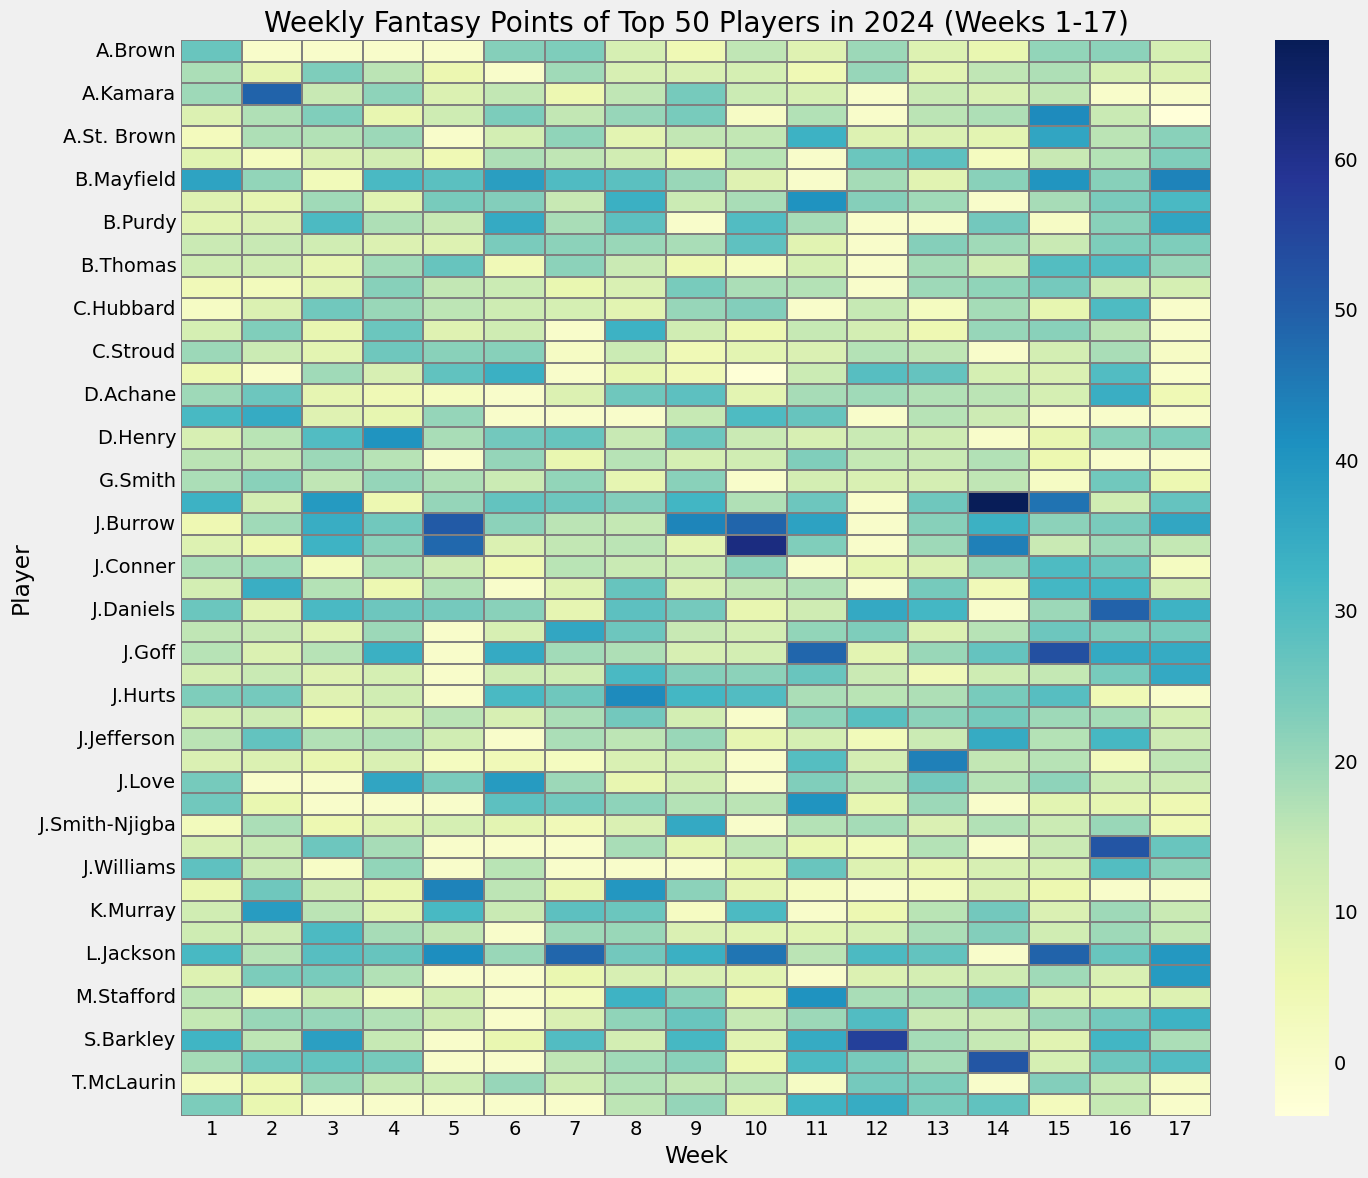

In [129]:
max_season = 2024
print("Using latest season:", max_season)

for column in merged_df.columns:
    print("Columns in merged_df:", column)

df_latest = merged_df[(merged_df['season'] == max_season) & (merged_df['week'] <= 17)].copy()
print(f"Rows in latest season up to week 17: {len(df_latest)}")

df_latest = compute_fantasy_points(df_latest)

total_points = df_latest.groupby('player_id')['fantasy_points_custom'].sum().reset_index()
print("Unique players with points:", len(total_points))

top_50_ids = total_points.nlargest(50, 'fantasy_points_custom')['player_id'].tolist()
print("Top 50 player_ids:", top_50_ids)

top_50_df = df_latest[df_latest['player_id'].isin(top_50_ids)].copy()
print(f"Rows for top 50 players up to week 17: {len(top_50_df)}")

weekly_points = top_50_df.groupby(['week', 'player_id', 'player_name_weekly'])['fantasy_points_custom'].sum().reset_index()
print("Weekly points rows:", len(weekly_points))

pivot = weekly_points.pivot(index='player_name_weekly', columns='week', values='fantasy_points_custom').fillna(0)
print("Pivot shape:", pivot.shape)

if pivot.empty:
    print("Pivot table is empty, no data to plot.")
else:
    plt.figure(figsize=(15, 12))
    sns.heatmap(pivot, cmap='YlGnBu', linewidths=0.3, linecolor='gray')
    plt.title(f"Weekly Fantasy Points of Top 50 Players in {max_season} (Weeks 1-17)")
    plt.xlabel("Week")
    plt.ylabel("Player")
    plt.tight_layout()
    plt.show()


In [130]:
agg_points = top_50_df.groupby('player_name_weekly')['fantasy_points_custom'].sum().sort_values(ascending=False)
print("\nAggregated fantasy points for Top 50 players (Weeks 1-17):")
print(agg_points)


Aggregated fantasy points for Top 50 players (Weeks 1-17):
player_name_weekly
L.Jackson         506.399999
J.Burrow          453.839999
J.Allen           440.339999
B.Mayfield        400.160000
J.Goff            396.720000
J.Daniels         386.599999
S.Barkley         369.799999
J.Chase           362.899999
S.Darnold         350.320000
J.Hurts           339.120000
B.Nix             326.160001
P.Mahomes         310.520001
D.Henry           309.800000
J.Gibbs           299.400000
K.Murray          296.360000
B.Purdy           294.860000
J.Love            291.100000
B.Robinson        280.900000
J.Herbert         277.360000
J.Jefferson       275.080000
J.Jacobs          266.000000
J.Cook            265.900001
A.St. Brown       261.979999
A.Rodgers         256.620000
K.Williams        255.099998
D.Achane          250.800001
B.Thomas          246.700000
G.Smith           237.680000
A.Kamara          237.300000
M.Stafford        236.580001
J.Conner          236.300000
C.Brown           230.

In [131]:
import nfl_data_py as nfl
import pandas as pd

def calculate_sos(year):
    """
    Calculates the Strength of Schedule (SOS) for all NFL teams in a given year.

    SOS is calculated as the average winning percentage of a team's opponents,
    excluding games played against the team itself to avoid bias.

    Args:
        year (int): The NFL season year (e.g., 2023).

    Returns:
        pd.DataFrame: A DataFrame with 'team', 'strength_of_schedule', and 'win_pct'
                      columns, sorted by SOS in descending order.
    """
    print(f"Calculating Strength of Schedule for the {year} NFL season...")

    try:
        # Step 1: Import play-by-play data for the specified year
        # This dataset contains information about each play, but we'll extract game-level outcomes.
        pbp_df = nfl.import_pbp_data([year])
        
        # Check if the DataFrame is empty, which indicates data is not available for the year
        if pbp_df.empty:
            print(f"Data not available for the {year} season. Please try a past season (e.g., 2023).")
            return pd.DataFrame() # Return an empty DataFrame

        print("Play-by-play data loaded successfully.")

        # Step 2: Extract unique game outcomes to get match results
        # We need game_id, season, week, teams involved, and final scores.
        games = pbp_df[['game_id', 'season', 'week', 'home_team', 'away_team', 'home_score', 'away_score']].drop_duplicates().reset_index(drop=True)
        print(f"Extracted {len(games)} unique games.")

        # Determine game outcomes (win/loss/tie) for easier calculation
        games['home_win'] = (games['home_score'] > games['away_score']).astype(int)
        games['away_win'] = (games['away_score'] > games['home_score']).astype(int)
        games['tie'] = (games['home_score'] == games['away_score']).astype(int)

        # Step 3: Calculate the final winning percentage for each team in the season
        team_records = {}
        # Get all unique teams that played in the season
        all_teams = pd.concat([games['home_team'], games['away_team']]).unique()

        for team in all_teams:
            # Games where the current team was the home team
            team_games_home = games[(games['home_team'] == team) & (games['season'] == year)]
            # Games where the current team was the away team
            team_games_away = games[(games['away_team'] == team) & (games['season'] == year)]

            # Sum up wins (1 point for win, 0.5 for tie)
            wins = team_games_home['home_win'].sum() + team_games_away['away_win'].sum() + \
                   (team_games_home['tie'].sum() * 0.5) + (team_games_away['tie'].sum() * 0.5)
            
            # Total games played by the team
            total_games = len(team_games_home) + len(team_games_away)
            
            # Calculate win percentage, handle division by zero for teams with no games (unlikely in NFL)
            win_percentage = wins / total_games if total_games > 0 else 0
            team_records[team] = win_percentage
        
        # Convert the dictionary of team records to a DataFrame for easy merging and lookup
        team_win_pct_df = pd.DataFrame.from_dict(team_records, orient='index', columns=['win_pct']).reset_index()
        team_win_pct_df.rename(columns={'index': 'team'}, inplace=True)
        print("Team winning percentages calculated.")
        
        # Step 4: Calculate Strength of Schedule for each team
        sos_data = []
        for team in team_win_pct_df['team']:
            # Get all opponents for the current team in the season
            # Find opponents when 'team' was home
            opponents_as_home = games[(games['home_team'] == team) & (games['season'] == year)]['away_team'].tolist()
            # Find opponents when 'team' was away
            opponents_as_away = games[(games['away_team'] == team) & (games['season'] == year)]['home_team'].tolist()
            
            all_opponents = opponents_as_home + opponents_as_away

            opponent_win_pcts = []
            for opp in all_opponents:
                # Find games where the opponent 'opp' played, EXCLUDING games against the current 'team'
                opp_games_home = games[(games['home_team'] == opp) & (games['season'] == year) & (games['away_team'] != team)]
                opp_games_away = games[(games['away_team'] == opp) & (games['season'] == year) & (games['home_team'] != team)]

                # Calculate the opponent's winning percentage based on *their* games, excluding the current team's games
                opp_wins = opp_games_home['home_win'].sum() + opp_games_away['away_win'].sum() + \
                           (opp_games_home['tie'].sum() * 0.5) + (opp_games_away['tie'].sum() * 0.5)
                opp_total_games = len(opp_games_home) + len(opp_games_away)

                opp_win_pct = opp_wins / opp_total_games if opp_total_games > 0 else 0
                opponent_win_pcts.append(opp_win_pct)

            # Average the winning percentages of all opponents
            if opponent_win_pcts:
                avg_opponent_win_pct = sum(opponent_win_pcts) / len(opponent_win_pcts)
            else:
                avg_opponent_win_pct = 0 # Should not happen for NFL teams in a full season

            sos_data.append({'team': team, 'strength_of_schedule': avg_opponent_win_pct})

        sos_df = pd.DataFrame(sos_data)
        print("Strength of Schedule calculated for all teams.")
        
        # Step 5: Merge SOS with original team win percentages and sort for final output
        final_df = pd.merge(sos_df, team_win_pct_df, on='team')
        final_df = final_df.sort_values(by='strength_of_schedule', ascending=False).reset_index(drop=True)
        
        return final_df

    except Exception as e:
        print(f"An error occurred: {e}")
        return pd.DataFrame() # Return empty DataFrame on error

sos = calculate_sos(2024)
print(sos)


Calculating Strength of Schedule for the 2024 NFL season...
2024 done.
Downcasting floats.
Play-by-play data loaded successfully.
Extracted 285 unique games.
Team winning percentages calculated.
Strength of Schedule calculated for all teams.
   team  strength_of_schedule   win_pct
0   BAL              0.552543  0.684211
1   DET              0.546631  0.833333
2    LA              0.546383  0.578947
3    GB              0.545265  0.611111
4    KC              0.544085  0.850000
5    SF              0.538381  0.352941
6   PHI              0.528270  0.857143
7   NYG              0.524965  0.176471
8   CHI              0.524316  0.294118
9   ARI              0.524278  0.470588
10  BUF              0.517104  0.750000
11  DAL              0.514757  0.411765
12   TB              0.509465  0.555556
13  DEN              0.508043  0.555556
14  PIT              0.506810  0.555556
15  ATL              0.505426  0.470588
16  CLE              0.505239  0.176471
17  HOU              0.503316  0.57894

In [132]:
import pandas as pd
file_path = 'schedule.txt'
with open(file_path, 'r') as file:
        file_content = file.read()

    
def generate_2025_nfl_schedule_csv(schedule_text):
    schedule_lines = schedule_text.strip().split('\n')
    games_data = []
    current_week = None

    nfl_teams = ["Arizona Cardinals", "Atlanta Falcons", "Baltimore Ravens", "Buffalo Bills", 
                 "Carolina Panthers", "Chicago Bears", "Cincinnati Bengals", "Cleveland Browns", 
                 "Dallas Cowboys", "Denver Broncos", "Detroit Lions", "Green Bay Packers", 
                 "Houston Texans", "Indianapolis Colts", "Jacksonville Jaguars", "Kansas City Chiefs", 
                 "Las Vegas Raiders", "Los Angeles Chargers", "Los Angeles Rams", "Miami Dolphins", 
                 "Minnesota Vikings", "New England Patriots", "New Orleans Saints", "New York Giants", 
                 "New York Jets", "Philadelphia Eagles", "Pittsburgh Steelers", "San Francisco 49ers", 
                 "Seattle Seahawks", "Tampa Bay Buccaneers", "Tennessee Titans", "Washington Commanders"]

    for line in schedule_lines:
        line = line.strip()
        
        if line.startswith("WEEK"):
            current_week = int(line.split()[1])
            continue 

        words = line.split()
        teams_in_line = [word for word in words if word in [team.split()[-1] for team in nfl_teams]]

        if len(teams_in_line) >= 2 and current_week is not None:
            team1 = None
            team2 = None
            for team in nfl_teams:
                if teams_in_line[0] in team:
                    team1 = team
                if teams_in_line[1] in team:
                    team2 = team
            if "at" in line:
                game = {
                    'Week': current_week,
                    'Away Team': team1,
                    'Home Team': team2
                }
            else:
                game = {
                    'Week': current_week,
                    'Away Team': team2,
                    'Home Team': team1
                }
            games_data.append(game)

    schedule_df = pd.DataFrame(games_data)
    return schedule_df

# Call the function to generate the DataFrame
schedule_df = generate_2025_nfl_schedule_csv(file_content)

# Write the DataFrame to a CSV file
if not schedule_df.empty:
    schedule_df.to_csv('nfl_schedule_2025.csv', index=False)
    print("NFL schedule CSV file generated successfully.")
else:
    print("No games found in the schedule.")

NFL schedule CSV file generated successfully.


In [133]:
import pandas as pd
from tabulate import tabulate

# Read the CSV file
schedule_df = pd.read_csv('nfl_schedule_2025.csv')

# Get the list of teams
teams = schedule_df['Home Team'].unique().tolist()

# Print schedule for each team
for team in teams:
    team_schedule = schedule_df[(schedule_df['Home Team'] == team) | (schedule_df['Away Team'] == team)].copy()
    team_schedule['Opponent'] = team_schedule.apply(lambda row: row['Away Team'] if row['Home Team'] == team else row['Home Team'], axis=1)
    team_schedule['Home/Away'] = team_schedule.apply(lambda row: 'vs' if row['Home Team'] == team else 'at', axis=1)
    team_schedule = team_schedule[['Week', 'Opponent', 'Home/Away']]
    print(f"Schedule for {team}:")
    print(tabulate(team_schedule, headers='keys', tablefmt='psql'))
    print("\n")
    break

Schedule for Green Bay Packers:
+-----+--------+-----------------------+-------------+
|     |   Week | Opponent              | Home/Away   |
|-----+--------+-----------------------+-------------|
|   0 |      1 | Washington Commanders | vs          |
|  18 |      2 | Cleveland Browns      | at          |
|  45 |      3 | Dallas Cowboys        | at          |
|  72 |      5 | Cincinnati Bengals    | vs          |
|  87 |      6 | Arizona Cardinals     | at          |
| 103 |      7 | Pittsburgh Steelers   | at          |
| 108 |      8 | Carolina Panthers     | vs          |
| 132 |      9 | Philadelphia Eagles   | vs          |
| 139 |     10 | New York Giants       | at          |
| 153 |     11 | Minnesota Vikings     | vs          |
| 162 |     12 | Detroit Lions         | at          |
| 182 |     13 | Chicago Bears         | vs          |
| 201 |     14 | Denver Broncos        | at          |
| 209 |     15 | Chicago Bears         | at          |
| 229 |     16 | Baltimore Ravens

Original Schedule Data:
   Week              Away Team           Home Team
0     1  Washington Commanders   Green Bay Packers
1     1       Cleveland Browns    Baltimore Ravens
2     1   Jacksonville Jaguars  Cincinnati Bengals
3     1        New York Giants      Dallas Cowboys
4     1          Chicago Bears       Detroit Lions
--------------------------------------------------
2024 Games Data:
              game_id  season game_type  week     gameday   weekday gametime  \
6706   2024_01_BAL_KC    2024       REG     1  2024-09-05  Thursday    20:20   
6707   2024_01_GB_PHI    2024       REG     1  2024-09-06    Friday    20:15   
6708  2024_01_PIT_ATL    2024       REG     1  2024-09-08    Sunday    13:00   
6709  2024_01_ARI_BUF    2024       REG     1  2024-09-08    Sunday    13:00   
6710  2024_01_TEN_CHI    2024       REG     1  2024-09-08    Sunday    13:00   

     away_team  away_score home_team  ...  wind  away_qb_id  home_qb_id  \
6706       BAL        20.0        KC  ...   8.

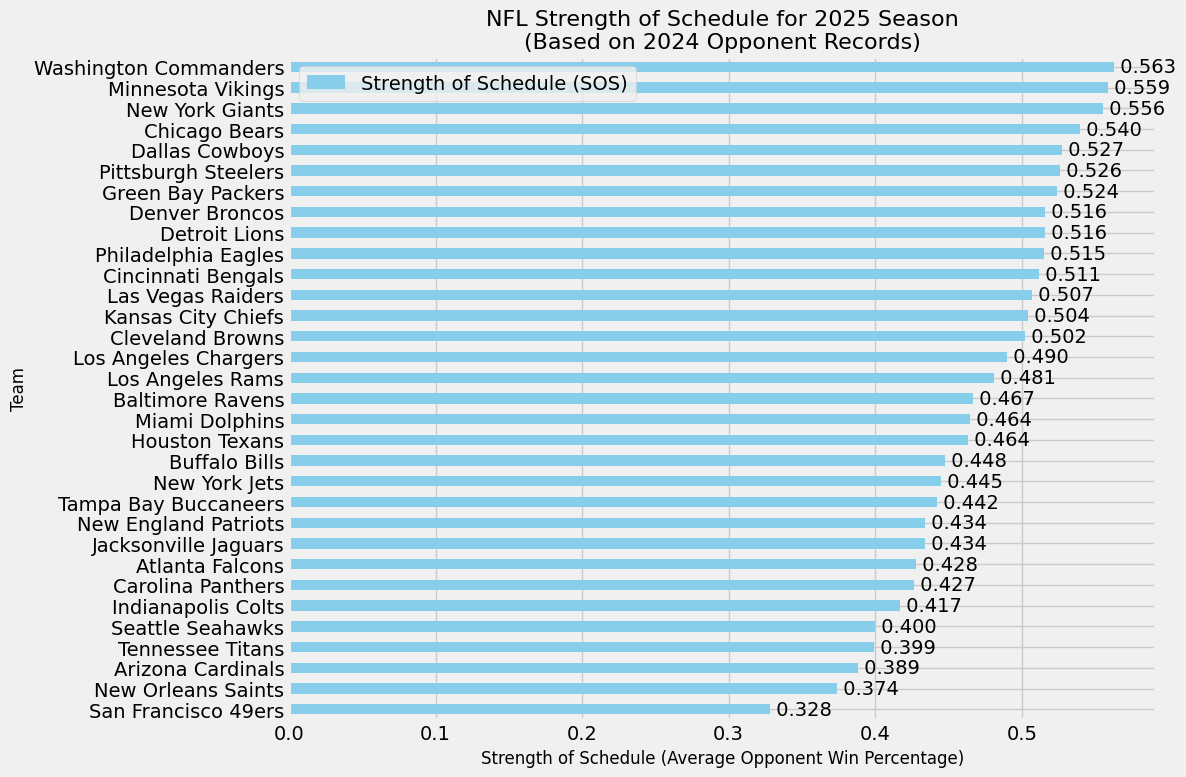

In [134]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Step 1: Read your schedule file ---
# This line assumes 'nfl_schedule_2025.csv' is in the same folder as this script.
schedule_df = pd.read_csv('nfl_schedule_2025.csv')
print("Original Schedule Data:")
print(schedule_df.head())
print("-" * 50)

# --- Step 2: Read 2024 game data from nflverse repository ---
GAMES_URL = 'https://raw.githubusercontent.com/nflverse/nfldata/master/data/games.csv'
games_df = pd.read_csv(GAMES_URL)
games_df = games_df[games_df['season'] == 2024]
print("2024 Games Data:")
print(games_df.head())
print("-" * 50)

# Map team names to abbreviations
team_abbreviations = {
    'Washington Commanders': 'WAS', 'Green Bay Packers': 'GB', 'Cleveland Browns': 'CLE', 'Baltimore Ravens': 'BAL',
    'Jacksonville Jaguars': 'JAX', 'Cincinnati Bengals': 'CIN', 'New York Giants': 'NYG', 'Dallas Cowboys': 'DAL',
    'Chicago Bears': 'CHI', 'Detroit Lions': 'DET', 'New England Patriots': 'NE', 'Miami Dolphins': 'MIA',
    'San Francisco 49ers': 'SF', 'New Orleans Saints': 'NO', 'Buffalo Bills': 'BUF', 'New York Jets': 'NYJ',
    'Seattle Seahawks': 'SEA', 'Pittsburgh Steelers': 'PIT', 'Los Angeles Rams': 'LAR', 'Tennessee Titans': 'TEN',
    'Carolina Panthers': 'CAR', 'Arizona Cardinals': 'ARI', 'Denver Broncos': 'DEN', 'Indianapolis Colts': 'IND',
    'Philadelphia Eagles': 'PHI', 'Kansas City Chiefs': 'KC', 'Atlanta Falcons': 'ATL', 'Minnesota Vikings': 'MIN',
    'Tampa Bay Buccaneers': 'TB', 'Houston Texans': 'HOU', 'Los Angeles Chargers': 'LAC', 'Las Vegas Raiders': 'LV'
}

# --- Step 3: Calculate win percentage for each team ---
team_records = {}
for team_abbr in team_abbreviations.values():
    home_games = games_df[games_df['home_team'] == team_abbr]
    away_games = games_df[games_df['away_team'] == team_abbr]

    wins = (home_games['result'] > 0).sum() + (away_games['result'] < 0).sum()
    losses = (home_games['result'] < 0).sum() + (away_games['result'] > 0).sum()
    ties = (home_games['result'] == 0).sum()

    total_games = wins + losses + ties
    if total_games > 0:
        win_pct = (wins + 0.5 * ties) / total_games
    else:
        win_pct = 0.0
    team_records[team_abbr] = win_pct

records_df = pd.DataFrame(team_records.items(), columns=['team_abbr', 'win_pct'])

# --- Step 4: Prepare the schedule for calculation ---
schedule_df['Away_abbr'] = schedule_df['Away Team'].map(team_abbreviations)
schedule_df['Home_abbr'] = schedule_df['Home Team'].map(team_abbreviations)

schedule_with_opp_win_pct = schedule_df.merge(
    records_df,
    left_on='Away_abbr',
    right_on='team_abbr',
    how='left',
    suffixes=('', '_away_opp_win_pct')
).rename(columns={'win_pct': 'Away_Opp_Win_Pct'}).drop(columns='team_abbr')

schedule_with_opp_win_pct = schedule_with_opp_win_pct.merge(
    records_df,
    left_on='Home_abbr',
    right_on='team_abbr',
    how='left',
    suffixes=('', '_home_opp_win_pct')
).rename(columns={'win_pct': 'Home_Opp_Win_Pct'}).drop(columns='team_abbr')

# --- Step 5: Calculate Strength of Schedule (SOS) for each team ---
sos_scores = {}
for team_name in schedule_df['Away Team'].unique():
    team_games = schedule_with_opp_win_pct[
        (schedule_with_opp_win_pct['Away Team'] == team_name) |
        (schedule_with_opp_win_pct['Home Team'] == team_name)
    ]

    opponents_win_pcts = []
    for index, row in team_games.iterrows():
        if row['Away Team'] == team_name:
            opponents_win_pcts.append(row['Home_Opp_Win_Pct'])
        else:
            opponents_win_pcts.append(row['Away_Opp_Win_Pct'])

    if opponents_win_pcts:
        sos = sum(opponents_win_pcts) / len(opponents_win_pcts)
    else:
        sos = 0.0

    sos_scores[team_name] = sos

sos_df = pd.DataFrame(sos_scores.items(), columns=['Team', 'Strength of Schedule (SOS)'])
sos_df = sos_df.sort_values(by='Strength of Schedule (SOS)', ascending=False).reset_index(drop=True)

print("Final Strength of Schedule (SOS) Rankings:")
print(sos_df)

# --- Step 6: Plot the results ---
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(12, 8))
sos_df.plot(kind='barh', x='Team', y='Strength of Schedule (SOS)', ax=ax, color='skyblue')

ax.set_title(f"NFL Strength of Schedule for 2025 Season\n(Based on 2024 Opponent Records)", fontsize=16)
ax.set_xlabel("Strength of Schedule (Average Opponent Win Percentage)", fontsize=12)
ax.set_ylabel("Team", fontsize=12)

# Invert y-axis to show highest SOS at the top
ax.invert_yaxis()

# Add SOS values as text labels on the bars
for index, value in enumerate(sos_df['Strength of Schedule (SOS)']):
    ax.text(value, index, f' {value:.3f}', va='center')

plt.tight_layout()
plt.savefig('strength_of_schedule.png')

In [155]:
import numpy as np
import pandas as pd
from collections import OrderedDict
from IPython.display import display
from collections import defaultdict
import random

import pandas as pd
import numpy as np
import warnings
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.preprocessing import StandardScaler, OneHotEncoder
import pandas as pd
import numpy as np
import warnings

def build_player_table(
    merged_df: pd.DataFrame,
    sos_df: pd.DataFrame,
    position_map: dict,
    min_games: int = 4,
    alpha_sos: float = 0.6,
    season_col: str = "season",
    verbose: bool = True
) -> tuple[pd.DataFrame, np.ndarray, dict]:
    """
    Builds a comprehensive player table for a fantasy football draft simulation.
    (Function body remains the same until the normalization step)
    """
    if verbose:
        print(f"Initial players in merged_df: {merged_df.shape[0]}")

    df = merged_df.copy()

    keep_base_cols = [
        "player_id", "player_name_weekly", "player_display_name", "position_weekly",
        "recent_team", "games", "team", "season", "age", "position_group"
    ]
    keep_fantasy_cols = [
        "fantasy_points_custom", "fantasy_points_season", "fantasy_points_ppr_season"
    ]
    statistical_features = [
        "years_exp", "draft_ovr", "receptions_season", "targets_season",
        "rushing_yards_season", "carries_season", "passing_yards_season",
        "passing_tds_season", "receiving_tds_season", "rushing_tds_season",
        "wopr_y", "dom", "yptmpa", "ppr_sh",
        "completions_season", "attempts_season", "interceptions_season",
        "sacks_season", "sack_yards_season", "sack_fumbles_season",
        "passing_air_yards_season", "passing_yards_after_catch_season",
        "passing_first_downs_season", "passing_epa_season",
        "rushing_fumbles_season", "rushing_fumbles_lost_season",
        "rushing_first_downs_season", "rushing_epa_season",
        "receiving_fumbles_season", "receiving_fumbles_lost_season",
        "receiving_air_yards_season", "receiving_yards_after_catch_season",
        "receiving_first_downs_season", "receiving_epa_season",
        "target_share_season", "air_yards_share_season",
        "wopr_x", "ry_sh", "rtd_sh", "rfd_sh", "rtdfd_sh", "w8dom",
        "total_two_point_conversions", "total_fumbles_lost", "total_yards"
    ]

    all_keep_cols = list(set(keep_base_cols + keep_fantasy_cols + statistical_features))

    for k in all_keep_cols:
        if k not in df.columns:
            warnings.warn(f"Column '{k}' not found. Adding as NaN.")
            df[k] = np.nan
    
    if "team" not in df.columns and "recent_team" in df.columns:
        df["team"] = df["recent_team"]
    elif "team" not in df.columns:
        df["team"] = np.nan

    fill_zero_for_stats = [col for col in statistical_features if col in df.columns]
    df[fill_zero_for_stats] = df[fill_zero_for_stats].fillna(0.0)
    
    grp_cols = ["player_id", season_col]
    
    agg_rules = {
        "player_name_weekly": "last", "player_display_name": "last",
        "position_weekly": "last", "recent_team": "last", "team": "last",
        "position_group": "last", "age": "last", "games": "max",
        "fantasy_points_custom": "sum", "fantasy_points_season": "max",
        "fantasy_points_ppr_season": "max",
    }
    for col in statistical_features:
        if col not in agg_rules and col in df.columns:
            agg_rules[col] = "sum"
            if col in ["wopr_y", "dom", "yptmpa", "ppr_sh"]:
                agg_rules[col] = "mean"

    valid_agg_rules = {k: v for k, v in agg_rules.items() if k in df.columns}
    
    g = df.groupby(grp_cols, dropna=False).agg(valid_agg_rules).reset_index()

    if verbose:
        print(f"Players after initial aggregation: {g.shape[0]}")

    g["proj_fp"] = g.get("fantasy_points_custom", pd.Series(0.0)).combine_first(
                        g.get("fantasy_points_season", pd.Series(0.0))).combine_first(
                        g.get("fantasy_points_ppr_season", pd.Series(0.0))).fillna(0.0)
    g["score"] = g["proj_fp"]

    g["games"].fillna(0, inplace=True)
    g = g[g["games"] >= min_games]
    
    g["pos"] = g["position_weekly"].fillna(g["position_group"]).fillna("")
    pos_vals = sorted([p for p in g["pos"].astype(str).unique() if p in position_map])
    pos_to_idx = {p: i for i, p in enumerate(pos_vals)}
    g["pos_idx"] = g["pos"].map(pos_to_idx).fillna(-1).astype(int)
    g = g[g["pos_idx"] != -1]
    
    if verbose:
        print(f"Players after filtering by min_games ({min_games}) and position: {g.shape[0]}")

    sos_df = sos_df.copy()
    sos_df.columns = [c.strip() for c in sos_df.columns]
    if "Team" in sos_df.columns and "Strength of Schedule (SOS)" in sos_df.columns:
        sos_df = sos_df.rename(columns={"Team": "team", "Strength of Schedule (SOS)": "sos"})
    
    sos_df["team"] = sos_df["team"].astype(str)
    g["team"] = g["team"].astype(str)
    
    g = g.merge(sos_df[["team", "sos"]], on="team", how="left")
    g["sos"].fillna(g["sos"].mean(), inplace=True)

    g["sos_adj"] = 1.0 - alpha_sos * (g["sos"] - g["sos"].mean())
    g["sos_adj"] = g["sos_adj"].clip(0.5, 1.5)
    g["proj_adj"] = (g["proj_fp"].fillna(0.0) * g["sos_adj"]).clip(0.0, None)
    g["proj_adj"] = g["proj_adj"].replace([np.inf, -np.inf], 0.0).fillna(0.0)
    g["age"] = g["age"].replace([np.inf, -np.inf], np.nan).fillna(g["age"].median() if not g["age"].empty else 25.0)
    g["name"] = g["player_display_name"].fillna(g["player_name_weekly"]).fillna("")

    # --- Feature Engineering and Normalization for X matrix ---
    numerical_features_for_X = [
        "proj_adj", "age", "years_exp", "draft_ovr", "receptions_season",
        "targets_season", "rushing_yards_season", "carries_season", "passing_yards_season",
        "passing_tds_season", "receiving_tds_season", "rushing_tds_season",
        "wopr_y", "dom", "yptmpa", "ppr_sh"
    ]
    numerical_features_for_X.extend([
        col for col in statistical_features if col not in numerical_features_for_X
        and col in g.columns
    ])
    numerical_features_for_X = list(set(numerical_features_for_X))

    existing_numerical_features_for_X = [f for f in numerical_features_for_X if f in g.columns]
    
    # 1. Select the numerical features and handle NaNs/infinities
    num_feats = g[existing_numerical_features_for_X].replace([np.inf, -np.inf], np.nan).fillna(0.0).to_numpy(dtype=np.float32)
    
    # 2. Normalize the numerical features using StandardScaler
    scaler = StandardScaler()
    num_feats_scaled = scaler.fit_transform(num_feats) 

    # 3. One-hot encode the categorical 'pos_idx' feature
    pos_idx_arr = g["pos_idx"].values.reshape(-1, 1)
    ohe = OneHotEncoder(categories=[range(len(pos_vals))], handle_unknown='ignore')
    pos_ohe = ohe.fit_transform(pos_idx_arr).toarray()
    
    # 4. Horizontally stack the normalized numerical features and the one-hot encoded features
    X = np.hstack((num_feats_scaled, pos_ohe)).astype(np.float32)
    
    g_indexed = g.set_index("player_id", drop=False)

    id_map = {i: player_id for i, player_id in enumerate(g_indexed.index.tolist())}
    
    if verbose:
        print(f"Final players in processed table: {g_indexed.shape[0]}")
        print(f"Feature matrix (X) shape: {X.shape}")
        print(f"ID map size: {len(id_map)}")

    return g_indexed, X, id_map

def suggest_draft(env, player_name, num_suggestions=10):
    """
    Provides draft suggestions based on a selected player.

    Args:
        env (DraftSim): The draft simulation environment.
        player_name (str): The name of the player to base suggestions on.
        num_suggestions (int): The number of suggestions to provide.
    
    Returns:
        pd.DataFrame: A DataFrame of suggested players.
    """
    # Find the player ID and integer index of the selected player
    # --- FIX: The `_get_player_id_from_name` method now returns both the player_id and the index.
    player_id, player_idx = env._get_player_id_from_name(player_name)
    
    if player_id is None:
        print(f"Player '{player_name}' not found.")
        return None

    # Get the nearest neighbors from the environment's internal state
    nearest_neighbors_indices = env.get_nearest_neighbors(player_idx, n=num_suggestions)
    
    # --- FIX: Use the `id_map` to get the player_id from the integer index
    # and then use `loc` to get the player data from the DataFrame.
    suggested_players_ids = [env.id_map[i] for i in nearest_neighbors_indices]
    suggested_players = env.df.loc[suggested_players_ids]
    
    return suggested_players

def run_interactive_draft(env):
    """
    Runs an interactive fantasy football draft simulation.

    Args:
        env (DraftSim): The draft simulation environment.
    """
    print("Welcome to the Interactive Fantasy Football Draft!")
    print("Your picks are based on your team's needs and position scarcity.")
    print("Bot picks are based on similar logic.")
    print("----------------------------------------------------------------")
    
    done = False
    
    while not done:
        # User's turn
        print(f"Current Team Needs: {env.team_needs}")
        player_name = input("Enter a player name to draft (or 'quit' to end): ")
        
        if player_name.lower() == 'quit':
            break
        
        # Look up the player ID and integer index from the name
        player_id, player_idx = env._get_player_id_from_name(player_name)
        
        if player_id is None:
            print(f"Player '{player_name}' not found. Please try again.")
            continue
        
        # Make the user's pick
        state, reward, done, info = env.step(player_idx)
        print(f"\nYou drafted: {player_id}. Reward: {reward:.2f}")

        if done:
            break
        
        # Bot's turn
        bot_idx = env._bot_pick()
        # --- FIX: The `_bot_pick` method returns an integer index. We need to look up the
        # player ID for the print statement.
        bot_player_id = env.id_map[bot_idx]
        
        # Make the bot's pick
        state, reward, done, info = env.step(bot_idx)
        print(f"The bot drafted: {bot_player_id}. Reward: {reward:.2f}")

        if done:
            break
    
    print("\n----------------------------------------------------------------")
    print("Draft complete!")
    print(f"Your final score: {env.final_score()}")
    print("----------------------------------------------------------------")

class DraftSim:
    def __init__(self, df, id_map, rounds=15):
        self.df = df
        self.id_map = id_map
        self.player_id_to_X_idx = {player_id: idx for idx, player_id in enumerate(self.df.index)}
        self.X = self.df.values

        self.rounds = rounds
        self.teams = 2
        self.total_picks = self.rounds * self.teams
        
        self.drafted_players_indices = []
        self.available_players_indices = list(range(len(self.X)))
        self.user_slot = 0
        
        self.team_needs = {
            "QB": 2, "RB": 2, "WR": 2, "TE": 1, "FLEX": 1, "K": 1, "DST": 1,
        }
        self.final_team = defaultdict(list)
        self.current_pick_number = 0

    def reset(self):
        self.drafted_players_indices = []
        self.available_players_indices = list(range(len(self.X)))
        self.team_needs = {
            "QB": 2, "RB": 2, "WR": 2, "TE": 1, "FLEX": 1, "K": 1, "DST": 1,
        }
        self.final_team = defaultdict(list)
        self.current_pick_number = 0
        
        # FIX: Return the observation dictionary as the first element.
        return self._get_observation(), 0, False, {}

    def step(self, action):
        if action not in self.available_players_indices:
            print(f"Player at index {action} is not available.")
            # FIX: Return the observation dictionary as the first element.
            return self._get_observation(), 0, False, {}
        
        player_data = self.df.iloc[action]
        player_position = player_data["position_weekly"]
        player_id = player_data.name

        self.available_players_indices.remove(action)
        self.drafted_players_indices.append(action)
        
        if self.current_pick_number % 2 == 0:
            self.final_team[player_position].append(player_id)
            if self.team_needs.get(player_position, 0) > 0:
                self.team_needs[player_position] -= 1
        
        reward = self._calculate_reward(player_data)
        self.current_pick_number += 1
        
        done = len(self.drafted_players_indices) >= self.total_picks
        
        # FIX: Return the observation dictionary as the first element.
        return self._get_observation(), reward, done, {}

    def _get_observation(self):
        avail_mask = np.zeros(len(self.df), dtype=bool)
        avail_mask[self.available_players_indices] = True
        
        turn_num = self.current_pick_number
        user_turn = 1 if self.current_pick_number % 2 == 0 else 0
        
        user_roster = [-1] * self.rounds
        team_players = self.final_team.get(self.user_slot, [])
        for i, player_id in enumerate(team_players):
            if i < self.rounds:
                user_roster[i] = self.player_id_to_X_idx.get(player_id, -1)
            
        return {
            "avail": avail_mask,
            "turn": turn_num,
            "user_turn": user_turn,
            "user_roster": user_roster,
        }
        
    def final_score(self):
        """Calculates the final score based on the drafted team."""
        total_score = 0
        for idx in self.drafted_players_indices:
            total_score += self.df.iloc[idx]['score']
        return total_score

    def _final_reward(self, team_slot):
        """
        Calculates the final reward for a given team slot.
        This is a placeholder that can be customized.
        
        Args:
            team_slot (int): The slot number of the team (e.g., 0 for user).
        
        Returns:
            float: The total score of the team.
        """
        # A simple implementation is to return the final score, but you could
        # customize this to be more complex if needed.
        return self.final_score()

        
    def _get_player_id_from_name(self, player_name):
        """
        Finds the player ID and integer index based on a partial or full name.
        
        Args:
            player_name (str): The name of the player to search for.

        Returns:
            tuple: A tuple containing the player ID (str) and the integer index (int)
                   or (None, None) if not found.
        """
        # Find all players that match the search name.
        matches = self.df[self.df["name"].str.contains(player_name, case=False, na=False)]
        
        if matches.empty:
            return None, None
        
        # Assuming the first match is the desired player.
        # --- FIX: Use the `id_map` to get the integer index from the player ID.
        player_id = matches.index[0]
        player_idx = self.player_id_to_X_idx.get(player_id)
        
        return player_id, player_idx

    def _calculate_weighted_reward(self, weights=None):
        """
        Calculates a weighted reward for each player based on various fantasy stats.
        
        Args:
            df (pd.DataFrame): The DataFrame containing player stats.
            weights (dict): A dictionary of weights for each stat.
        
        Returns:
            pd.DataFrame: The DataFrame with a new 'weighted_reward' column.
        """
        # Define default weights if none are provided
        if weights is None:
            weights = {
                'fantasy_points_custom': 0.6,
                'touchdowns': 0.2,
                'total_yards': 0.1,
                'receptions': 0.1
            }
        
        player_stats = df.groupby('player_id').agg(
            fantasy_points_custom=('fantasy_points_custom', 'sum'),
            touchdowns=('touchdowns', 'sum'),
            total_yards=('total_yards', 'sum'),
            receptions=('receptions', 'sum')
        ).fillna(0)  # Fill NaNs in aggregated columns with 0
    
        for col in weights.keys():
            min_val = player_stats[col].min()
            max_val = player_stats[col].max()
            # Ensure we don't divide by zero if max and min are the same
            if max_val > min_val:
                player_stats[f'norm_{col}'] = (player_stats[col] - min_val) / (max_val - min_val)
            else:
                player_stats[f'norm_{col}'] = 0
                
        player_stats['weighted_reward'] = 0
        for col, weight in weights.items():
            player_stats['weighted_reward'] += player_stats[f'norm_{col}'] * weight
        df['weighted_reward'] = df['player_id'].map(player_stats['weighted_reward']).fillna(0)
        return df
        
    def _calculate_reward(self, player_data):
        """
        Calculates the reward for picking a player.
        
        Args:
            player_data (pd.Series): The row of data for the picked player.
        
        Returns:
            float: The reward value.
        """
        self._calculate_weighted_reward(player_data)
        print('weighted_reward' in merged_df.columns)
        return player_data["weighted_reward"]

    def get_nearest_neighbors(self, player_idx, n=10):
        """
        Finds the nearest available players based on cosine similarity.
        
        Args:
            player_idx (int): The integer index of the player to get neighbors for.
            n (int): The number of neighbors to return.

        Returns:
            list: A list of integer indices of the nearest available players.
        """
        # This is a dummy implementation. A real one would use a precomputed similarity matrix
        # and would need to filter by `self.available_players_indices`.
        
        # --- FIX: Ensure the returned neighbors are from the list of available players
        # to avoid drafting players that have already been picked.
        
        all_players_copy = self.available_players_indices[:]
        
        # Shuffle the list to simulate a random selection of "nearest" players.
        random.shuffle(all_players_copy)
        
        # Exclude the current player and return the top `n` available players.
        if player_idx in all_players_copy:
            all_players_copy.remove(player_idx)
            
        return all_players_copy[:n]

    def _bot_pick(self):
        """
        Simulates a bot's pick.
        
        Returns:
            int: The integer index of the player to be picked by the bot.
        """
        # This is a dummy implementation. A real bot would use a more sophisticated
        # strategy based on team needs, player rankings, etc.
        
        # For this example, the bot simply picks the highest-ranked available player.
        # This is a simplification and would be much more sophisticated in a real application.
        
        # Get the sorted list of available player indices based on their score.
        available_scores = self.df.loc[self.df.index[self.available_players_indices], 'score'].sort_values(ascending=False)
        
        # --- FIX: The `id_map` has string keys (player_id) and integer values (index).
        # We need to get the player ID from the `available_scores` index and then
        # use the reverse map to get the correct integer index.
        highest_ranked_player_id = available_scores.index[0]
        bot_pick_idx = self.player_id_to_X_idx[highest_ranked_player_id]
        
        return bot_pick_idx
            
class Policy(nn.Module):
    def __init__(self, feat_dim: int, hidden: int = 256):
        super().__init__()
        # FIX: Remove the '+2' here, as the calling code already adds it.
        # This layer takes `feat_dim` as the input, which is `X.shape[1] + 2`.
        self.net = nn.Sequential(
            nn.Linear(feat_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 1)
        )
    def forward(self, X, avail_mask, turn_feat):
        n = X.shape[0]
        tf = turn_feat.expand(n, -1)
        z = torch.cat([X, tf], dim=1)
        logits = self.net(z).squeeze(-1)
        logits = logits.masked_fill(avail_mask < 0.5, -1e9)
        return logits

class ValueFn(nn.Module):
    def __init__(self, feat_dim: int, rounds: int):
        super().__init__()
        # The new input dimension:
        # 2 (for turn_feat) + feat_dim (mean of roster features) + (rounds * feat_dim) (flattened roster features)
        input_dim = 2 + feat_dim + (rounds * feat_dim)
        
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, states):
        return self.net(states)

def sample_episode(env, policy, X_t, max_steps=84, return_states=False):
    # FIX: Correctly unpack the tuple and use the `obs_dict` for observations.
    obs_dict, _, _, info = env.reset()
    
    device = X_t.device
    logps, rewards, actions, states = [], [], [], []

    for step in range(max_steps):
        # FIX: Use `obs_dict` instead of `info`.
        avail = torch.tensor(obs_dict["avail"], device=device, dtype=torch.bool)
        turn_feat = torch.tensor(
            [[obs_dict["turn"] / max(1, env.total_picks), float(obs_dict["user_turn"])]],
            device=device, dtype=torch.float32
        )
        logits = policy(X_t, avail, turn_feat)
        logits = torch.nan_to_num(logits, nan=0.0, posinf=1e6, neginf=-1e6)
        logits = torch.clamp(logits, min=-1e6, max=1e6)
        dist = torch.distributions.Categorical(logits=logits)
        a = logits.argmax()
        logps.append(dist.log_prob(a))
        actions.append(a.item())

        # Collect states for the value function
        current_roster_features = torch.zeros(env.rounds, X_t.shape[1], device=device)
        # FIX: Use `obs_dict` for the user roster
        for i, pid in enumerate(obs_dict["user_roster"]):
            if pid >= 0:
                current_roster_features[i] = X_t[pid]
        state_vector = torch.cat([turn_feat.squeeze(0), current_roster_features.mean(dim=0), current_roster_features.flatten()])
        states.append(state_vector.unsqueeze(0))

        # FIX: Unpack the tuple from `env.step()` and re-assign `obs_dict`.
        obs_dict, _, done, _ = env.step(a.item())

        if done:
            final_reward = env.final_score() # Use final_score as it's a public method
            rewards.append(final_reward)
            break
        else:
            rewards.append(0.0)
    
    returns = compute_returns(rewards).to(device)
    adv = (returns - returns.mean()) / (returns.std() + 1e-8)

    if return_states:
        states = torch.cat(states, dim=0).to(device)
        return torch.stack(logps), returns, adv, actions, states

    return torch.stack(logps), returns, adv, actions
    
def train_policy(env: DraftSim, policy: Policy, value_fn: ValueFn, X_t: torch.Tensor, epochs: int = 200, lr: float = 3e-4):
    opt_pi = optim.Adam(policy.parameters(), lr=lr)
    opt_v = optim.Adam(value_fn.parameters(), lr=lr)

    for ep in range(epochs):
        # Run one episode
        logps, returns, adv, actions, states = sample_episode(env, policy, X_t, return_states=True)

        # --- Policy update ---
        loss_pi = -(logps * adv).mean()
        opt_pi.zero_grad()
        loss_pi.backward()
        nn.utils.clip_grad_norm_(policy.parameters(), 1.0)
        opt_pi.step()

        # --- Value function update ---
        # Pass the episode states through the value network
        v_pred = value_fn(states).squeeze(-1)
        loss_v = nn.functional.mse_loss(v_pred, returns)
        opt_v.zero_grad()
        loss_v.backward()
        nn.utils.clip_grad_norm_(value_fn.parameters(), 1.0)
        opt_v.step()
        
        if (ep + 1) % 50 == 0:
            final_reward = env._final_reward(env.user_slot)
            print(f"Epoch {ep+1}: Final team score = {final_reward:.2f}")
        
    return policy


def suggest_draft(env, policy, X_t):
    # FIX: Correctly unpack the tuple from env.reset()
    obs, _, _, _ = env.reset()
    device = X_t.device
    
    suggested_picks = []
    done = False
    
    while not done:
        # FIX: Use the unpacked dictionary `obs`
        avail = torch.tensor(obs["avail"], dtype=torch.bool, device=device)
        turn_feat = torch.tensor(
            [[obs["turn"] / max(1, env.total_picks), float(obs["user_turn"])]],
            dtype=torch.float32, device=device
        )
        
        # --- Policy network logic to get a draft pick ---
        logits = policy(X_t, avail, turn_feat)
        logits = torch.nan_to_num(logits, nan=0.0, posinf=1e6, neginf=-1e6)
        action_prob = torch.softmax(logits, dim=-1)
        action_score = action_prob.max().item()
        
        # Select the action with the highest probability
        action_idx = torch.argmax(logits).item()
        
        # Store the pick's data
        player_name = env.df.iloc[action_idx]["name"]
        player_position = env.df.iloc[action_idx]["position_weekly"]
        name_pos = f"{player_name} ({player_position})"
        suggested_picks.append((action_idx, action_score, name_pos))
        
        # Take a step in the environment
        # FIX: Correctly unpack the tuple from env.step() and reassign `obs`
        obs, _, done, _ = env.step(action_idx)
    
    return suggested_picks



In [156]:
# Assuming your DraftSim class takes a DataFrame and an ID map
env = DraftSim(df=players_df, id_map=id_map)

# Your existing code
position_map = {
    "QB": "Quarterback",
    "RB": "Running Back",
    "WR": "Wide Receiver",
    "TE": "Tight End",
    "K": "Kicker",
    "DST": "Defense/Special Teams"
}

players_df, X, id_map = build_player_table(
    merged_df,
    sos_df,
    position_map=position_map
)

feat_dim = X.shape[1]

# The Policy network's input is X + turn_feat (2 features)
policy = Policy(feat_dim=feat_dim + 2).to(DEVICE)

# The ValueFn network's input is just X (no turn_feat)
value_fn = ValueFn(feat_dim=feat_dim, rounds=env.rounds).to(DEVICE)

X_t = torch.tensor(X, dtype=torch.float32, device=DEVICE)

print("Starting training...")
train_policy(env, policy, value_fn, X_t, epochs=5000)
print("Training complete!")
picks = suggest_draft(env, policy, X_t)
print("\nSuggested picks from the trained policy:")
for i, (action_idx, score, name_pos) in enumerate(picks):
    print(f"Pick {i+1}: {name_pos} (Score: {score:.2f})")

Initial players in merged_df: 38568
Players after initial aggregation: 4351
Players after filtering by min_games (4) and position: 3044
Final players in processed table: 3044
Feature matrix (X) shape: (3044, 51)
ID map size: 3044
Starting training...


/home/mtrottie/code/RecommenderSystems/.env/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


KeyError: "Column(s) ['fantasy_points_custom', 'total_yards', 'touchdowns'] do not exist"